<a href="https://colab.research.google.com/github/Siftee150/How_Many_topics/blob/master/Nematode_Biology/Research_Papers/paper-1/Paper_1_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 import pandas as pd
import re
import nltk
import matplotlib
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
import gensim
import random
import numpy as np
from gensim.models import CoherenceModel, LdaModel
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
#DOWNLOADING ALL RELEVANT LIBRARIES

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
################################PREPROCESSING THE DATASET##########################
#FINDING ALL RELEVANT REGEX OPERATORS
rx_dict = {
    'keys': re.compile(r'Key: (?P<keys>.*)\n'),
    'medline': re.compile(r'Medline: (?P<medline>\d+)\n'),
    'authors': re.compile(r'Authors: (?P<authors>.*)\n'),
    'title': re.compile(r'Title: (?P<title>.*)'),
    'citation': re.compile(r'Citation: (?P<citation>.*)'),
    'type': re.compile(r'Type: (?P<type>.*)'),
    'genes': re.compile(r'Genes: (?P<genes>.*)'),
    'abstract': re.compile(r'Abstract: (?P<abstract>.*)'),
    'end':re.compile(r'-------------------')
    }
    

In [3]:
def _findregex(line):
  for key,rx in rx_dict.items():
    match=rx.search(line)
    if match:
      return key,match
  return None,None

In [4]:
#PARSING THE TEXT FILE
def parse_file(filepath):
  data=[]
  keyval='-'
  medval='-'
  author_val='-'
  title_val='-'
  citation_val='-'
  type_val='-'
  genes_val='-'
  abstract_val='-'

  with open(filepath,'r') as file_object:
    line=file_object.readline()
    while line:
      key,match=_findregex(line)
      if key =='keys':
        keyval=match.group('keys')
      if key =='medline':
        medval=match.group('medline')
      if key =='authors':
        author_val=match.group('authors')
      if key =='title':
        title_val=match.group('title')
      if key =='citation':
        citation_val=match.group('citation')
      if key =='type':
        type_val=match.group('type')
      if key =='genes':
        genes_val=match.group('genes')
      if key =='abstract':
        abstract_val=match.group('abstract')
      if key=='end':
        row = {
          'Key': keyval,
          'Medline': medval,
          'Authors': author_val,
          'Title': title_val,
          'Citation': citation_val,
          'Type': type_val,
          'Genes': genes_val,
          'Abstract': abstract_val ,
          }
        data.append(row)
      line=file_object.readline()
    data=pd.DataFrame(data)
    return data

In [5]:
#LOADING TEXTFILE AND APPLYING PARSE_FILE FUNCTION ON IT
Finaldata=parse_file('/content/textfile.txt')
print(Finaldata.head(1))
######TEXT FILE DELIMITED

    Key Medline  ... Genes                                           Abstract
0     3       -  ...     -  Applying a series of techniques intended to in...

[1 rows x 8 columns]


In [6]:
###########3PREPROCESSING ON PARSED TEXT FILE 
#PUNCTUATION REMOVAL
def remove_punct(text):
  return text.translate(str.maketrans('', '', string.punctuation))
#STOPWORDS REMOVAL
def remove_stopword(text):
  STOPWORD = set(stopwords.words('english'))
  return " ".join([word for word in str(text).split() if word not in STOPWORD])
lemmatise = WordNetLemmatizer()
#LEMMATIZATION
def lemmatize_word(text):
    return " ".join([lemmatise.lemmatize(word) for word in text.split()])
ps = PorterStemmer()
#STEMMING
def stem_doc(text):
    return " ".join([ps.stem(word) for word in text.split()])

In [7]:
######APPLYING ALL PREPROCESSINF FUNCTIONS ON TITLE
Finaldata["Title_cleaned"]=Finaldata["Title"].str.lower()
Finaldata["Title_cleaned"]=Finaldata["Title_cleaned"].apply(lambda text:remove_punct(text))
Finaldata["Title_cleaned"]=Finaldata["Title_cleaned"].apply(lambda text:remove_stopword(text))
Finaldata["Title_cleaned"]=Finaldata["Title_cleaned"].apply(lambda text:lemmatize_word(text))
Finaldata["Title_cleaned"]=Finaldata["Title_cleaned"].apply(lambda text:stem_doc(text))
Finaldata.head()

,Key,Medline,Authors,Title,Citation,Type,Genes,Abstract,Title_cleaned
0,3,-,Abdulkader N;Brun JL,"Induction, detection and isolation of temperat...",Revue de Nematologie 1: 27-37 1978,ARTICLE,-,Applying a series of techniques intended to in...,induct detect isol temperaturesensit
1,5,-,Abi-Rached M;Brun JL,Etude ultrastructurale des relations entre ovo...,Nematologica 21: 151-162 1975,ARTICLE,-,"Before diakinesis, the development of the oocy...",etud ultrastructural de relat entr ovocyt et
2,6,-,Abi-Rached M;Brun JL,Ultrastructural changes in the nuclear and per...,Revue de Nematologie 1: 63-72 1978,ARTICLE,-,Electron microscope studies in and around the ...,ultrastructur chang nuclear perinuclear
3,7,-,Abi-Rached M;Brun JL,Changes in the synaptonemal complex in the ooc...,C.R. des Seances de l'Academie des Sciences Se...,ARTICLE,-,During oogenesis in the hermaphroditic nematod...,chang synaptonem complex oocyt nucleu
4,8,78127686,Albertson DG;Sulston JE;White JG,Cell cycling and DNA replication in a mutant b...,Developmental Biology 63: 165-178 1978,ARTICLE,lin-5 nuc-1,The postembryonic development of the nematode,cell cycl dna replic mutant block


In [8]:
#DROPPING IRRELEVANT COLUMNS 
Finaldata=Finaldata.drop(['Citation', 'Genes', 'Type'],axis=1)

In [9]:
######APPLYING ALL PREPROCESSING FUNCTIONS ON ABSTRACT COLUMN
Finaldata["Abstract_cleaned"]=Finaldata["Abstract"].str.lower()
Finaldata["Abstract_cleaned"]=Finaldata["Abstract_cleaned"].apply(lambda text:remove_punct(text))
Finaldata["Abstract_cleaned"]=Finaldata["Abstract_cleaned"].apply(lambda text:remove_stopword(text))
Finaldata["Abstract_cleaned"]=Finaldata["Abstract_cleaned"].apply(lambda text:lemmatize_word(text))
Finaldata["Abstract_cleaned"]=Finaldata["Abstract_cleaned"].apply(lambda text:stem_doc(text))
Finaldata.head()

,Key,Medline,Authors,Title,Abstract,Title_cleaned,Abstract_cleaned
0,3,-,Abdulkader N;Brun JL,"Induction, detection and isolation of temperat...",Applying a series of techniques intended to in...,induct detect isol temperaturesensit,appli seri techniqu intend induc detect
1,5,-,Abi-Rached M;Brun JL,Etude ultrastructurale des relations entre ovo...,"Before diakinesis, the development of the oocy...",etud ultrastructural de relat entr ovocyt et,diakinesi develop oocyt c
2,6,-,Abi-Rached M;Brun JL,Ultrastructural changes in the nuclear and per...,Electron microscope studies in and around the ...,ultrastructur chang nuclear perinuclear,electron microscop studi around nucleu c
3,7,-,Abi-Rached M;Brun JL,Changes in the synaptonemal complex in the ooc...,During oogenesis in the hermaphroditic nematod...,chang synaptonem complex oocyt nucleu,oogenesi hermaphrodit nematod c elegan
4,8,78127686,Albertson DG;Sulston JE;White JG,Cell cycling and DNA replication in a mutant b...,The postembryonic development of the nematode,cell cycl dna replic mutant block,postembryon develop nematod


In [10]:
########FINAL TEXT TO BE USED IN TOPIC MODELLNG IS COMBINATION OF
#TITLE AND ABSTRACT
Finaldata["FinalText"]=Finaldata["Title_cleaned"]+" "+Finaldata["Abstract_cleaned"]
Finaldata["FinalText"]=Finaldata["FinalText"].apply(lambda text:nltk.word_tokenize(text))
Finaldata["FinalText"]

0       [induct, detect, isol, temperaturesensit, appl...
1       [etud, ultrastructural, de, relat, entr, ovocy...
2       [ultrastructur, chang, nuclear, perinuclear, e...
3       [chang, synaptonem, complex, oocyt, nucleu, oo...
4       [cell, cycl, dna, replic, mutant, block, poste...
                              ...                        
6210    [latrophilin, requir, toxic, black, widow, spi...
6211    [abc, transport, gene, famili, caenorhabd, ele...
6212    [squeez, egg, worm, c, elegan, embryon, review...
6213    [centrosom, biolog, sassi, centriol, cell, cyc...
6214    [role, calponin, gene, profil, metastat, metas...
Name: FinalText, Length: 6215, dtype: object

In [11]:
Finaldata.head()

,Key,Medline,Authors,Title,Abstract,Title_cleaned,Abstract_cleaned,FinalText
0,3,-,Abdulkader N;Brun JL,"Induction, detection and isolation of temperat...",Applying a series of techniques intended to in...,induct detect isol temperaturesensit,appli seri techniqu intend induc detect,"[induct, detect, isol, temperaturesensit, appl..."
1,5,-,Abi-Rached M;Brun JL,Etude ultrastructurale des relations entre ovo...,"Before diakinesis, the development of the oocy...",etud ultrastructural de relat entr ovocyt et,diakinesi develop oocyt c,"[etud, ultrastructural, de, relat, entr, ovocy..."
2,6,-,Abi-Rached M;Brun JL,Ultrastructural changes in the nuclear and per...,Electron microscope studies in and around the ...,ultrastructur chang nuclear perinuclear,electron microscop studi around nucleu c,"[ultrastructur, chang, nuclear, perinuclear, e..."
3,7,-,Abi-Rached M;Brun JL,Changes in the synaptonemal complex in the ooc...,During oogenesis in the hermaphroditic nematod...,chang synaptonem complex oocyt nucleu,oogenesi hermaphrodit nematod c elegan,"[chang, synaptonem, complex, oocyt, nucleu, oo..."
4,8,78127686,Albertson DG;Sulston JE;White JG,Cell cycling and DNA replication in a mutant b...,The postembryonic development of the nematode,cell cycl dna replic mutant block,postembryon develop nematod,"[cell, cycl, dna, replic, mutant, block, poste..."


IMPLEMENTATION OF RESEARCH PAPER \
STEPS OF THE ALGORITHM:- \
1)For value of 'k'(number of topics) in a predefined range \
2)First apply LDA on the complete dataset and represent the output as a reference ranking set(S0) \
3)Then take up a fixed number of subsets of dataset with 80% of the total document content \
4)For each sample of dataset,apply topic modelling on it and calculate its reference ranking set Si \
5)Calculate the agreement score between S0 and Si \
6)Calculate mean agreement between all samples \

In [12]:
#FIRST IMPLEMENTING LDA ON DATASET
#using lda algorithm on preprocessed data
dictionary=gensim.corpora.Dictionary(Finaldata["FinalText"])
#dictionary
bow_corpus = [dictionary.doc2bow(doc) for doc in Finaldata["FinalText"]]
bow_corpus

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1)],
 [(9, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1)],
 [(9, 1),
  (16, 1),
  (21, 1),
  (25, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1)],
 [(11, 1),
  (32, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1)],
 [(9, 1), (30, 2), (42, 1), (43, 1), (44, 2)],
 [(30, 1),
  (32, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1)],
 [(9, 1),
  (30, 1),
  (32, 1),
  (43, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1)],
 [(9, 1),
  (30, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 2),
  (60, 1),
  (61, 1),
  (62, 1)],
 [(9, 1), (30, 2), (43, 1), (63, 1), (64, 1), (65, 2), (66, 1)],
 [(11, 1),
  (27, 1),
  (32, 1),
  (39, 1),
  (67, 1

In [13]:
#########LDA 
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

In [14]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.047*"protein" + 0.023*"elegan" + 0.017*"caenorhabd" + 0.014*"gene" + 0.013*"famili" + 0.011*"c" + 0.009*"cell" + 0.009*"function" + 0.009*"background" + 0.009*"homolog"
Topic: 1 
Words: 0.034*"c" + 0.032*"elegan" + 0.031*"cell" + 0.026*"gene" + 0.024*"regul" + 0.015*"signal" + 0.013*"protein" + 0.013*"earli" + 0.010*"control" + 0.009*"embryo"
Topic: 2 
Words: 0.038*"rna" + 0.023*"cell" + 0.016*"nuclear" + 0.013*"interfer" + 0.013*"receptor" + 0.012*"gene" + 0.011*"rnai" + 0.011*"axon" + 0.011*"requir" + 0.008*"neuron"
Topic: 3 
Words: 0.108*"elegan" + 0.102*"caenorhabd" + 0.046*"nematod" + 0.042*"gene" + 0.023*"c" + 0.011*"genom" + 0.010*"express" + 0.009*"function" + 0.009*"two" + 0.008*"sequenc"
Topic: 4 
Words: 0.047*"protein" + 0.018*"elegan" + 0.013*"caenorhabd" + 0.011*"signal" + 0.011*"kinas" + 0.009*"genet" + 0.008*"c" + 0.007*"g" + 0.007*"map" + 0.007*"heat"
Topic: 5 
Words: 0.016*"nematod" + 0.016*"life" + 0.014*"age" + 0.013*"mutant" + 0.011*"genet" + 0.01

In [15]:
def apply_LDA(sample,no_topics):
  sub_dictionary=gensim.corpora.Dictionary(sample)
  sub_bow_corpus = [sub_dictionary.doc2bow(doc) for doc in sample]
  sub_lda_model=gensim.models.LdaMulticore(sub_bow_corpus, 
                                   num_topics = no_topics , 
                                   id2word = sub_dictionary,                                    
                                   passes = 10,
                                   workers = 2)
  num_topics = no_topics
  topic_words = []
  for i in range(num_topics):
    tt = sub_lda_model.get_topic_terms(i,20)
    topic_words.append([dictionary[pair[0]] for pair in tt])
  return topic_words;

In [16]:

def rcs(inter):
  flag=1 
  """
  flag acts as an indicator of whether row and column scanning operations are continuing to produce modified outputs on the given matrix
  If flag=0 across the whole loop,we will have to break out of loop 
  """
  while((inter==0).any()==True and flag==1):
    flag=0
    #print("Row scanning")
    for row in inter:
      if(((row==0).sum())==1): #If only one zero is present across that row then mask the column correspondng to it and continue
        flag=1
        col_idex=np.where(row == 0)[0][0]
        m = np.zeros_like(inter)
        m[:,col_idex]=1
        inter=np.ma.MaskedArray(inter,m) #https://stackoverflow.com/questions/14611250/mask-specific-columns-of-a-numpy-array
    #print(inter) #Result of row scanning
    
    #print("Column scanning") 

    for j in range(len(inter)): #only one zero is present across that column,mask the row corresponding to it
      col=inter[:,j]
      if(((col==0).sum())==1):
        flag=1
        row_idex=np.where(col==0)[0][0]
        m=np.zeros_like(inter)
        m[row_idex,:]=1
        inter=np.ma.MaskedArray(inter,m)
   # print(inter)    #Result of column scanning

  if (inter.all() is np.ma.masked): #If all rows and columns are masked the lines are 3 and not 6
    return inter,len(inter)
  else:
    lines = np.count_nonzero(np.ma.count_masked(inter, axis=1)==len(inter))
    lines=lines+np.count_nonzero(np.ma.count_masked(inter, axis=0)==len(inter))
    return inter,lines

In [17]:
def o_a(inter,row_idex): 
  """
   The assignment will be where the 0's 
   are in the matrix such that only one 0 per row and column is part of the assignment.
  """ 

  # A recursive approach to find the optimum assignment of distinct positions for the matrix  
  
  if(row_idex>=len(inter)):
    a=[]
    return a
    
  for ele in np.where(inter[row_idex,:]==0)[0]:
    m = np.zeros_like(inter)
    m[:,ele]=1
    am=np.ma.MaskedArray(inter,m)
    a=o_a(am,row_idex+1)
    if (a != None):
      idx=str(row_idex)+","+str(ele)
      a.append(idx)
      return a
  return None







In [18]:
def check_random(inter):
  #print("checking in")
  i,j=random.choice(np.argwhere(inter==0))
  m = np.zeros_like(inter)
  n=random.randint(0,1)
  if(n==1):
    m[:,j]=1
  else:
    m[i,:]=1
  inter=np.ma.MaskedArray(inter,m)
  #print(inter)
  return inter

In [19]:
def hungarian_method(costmatrix,typ):
  inter=costmatrix
  if(typ=="Mx"):
    #converting the minimum cost bipartite problem to maximum cost bipartite problem
   # print("converting the minimum cost bipartite problem to maximum cost bipartite problem")
    inter=-costmatrix+np.amax(costmatrix)
  #  print(inter)
  #else no change to inter array
  
  #Subtract the smallest value in each row from the other values in the row:
  #print("Subtracting the minimum element along each row(axis=1) from all other elements in that row")
  inter=inter-np.amin(inter,axis=1)[:,None] #https://stackoverflow.com/questions/55251002/subtracting-minimum-of-row-from-the-row
 # print(inter)
  
  #subtract the smallest value in each column from all other values in the column
  #print("Subtracting the minimum element along each column(axis=0)  from all other elements in that column")
  inter=inter-np.amin(inter,axis=0)
  #print(inter)
  
  spare=inter
  oo_a=None
  
  inter,lines=rcs(inter)
  inter2=inter
  while(oo_a==None):
    inter2=inter
    while ((inter2==0).any()==True):
      inter2=check_random(inter2)
      inter2,lines=rcs(inter2)
    if (lines==len(costmatrix)):
      inter2.mask = np.ma.nomask
      oo_a=o_a(inter2,0)
    elif (lines>len(costmatrix)):
      continue
    else:
      break

  inter=inter2
  
  #print("Min number of lines required to cover all zeros of array",str(lines))
  
  while (lines<len(costmatrix)):
    #print("ITERATION!!!")
    min_t=np.amin(inter) #Find the smallest entry not covered by any line. 
    inter=inter-min_t  #subtracted from all non-masked elements i.e all elements not part of any crossed out row
    colns=np.argwhere(np.ma.count_masked(inter, axis=0)==len(inter))#count all crossed out columns
    #print(colns) #display those columns(could strike this off as per your needs)
    rns=np.argwhere(np.ma.count_masked(inter, axis=1)==len(inter)) #count all crossed out rows
    #print(rns)   #display those rows(could strike this off as per your needs)
    for ele in rns:
      for i in ele:
        for elem in colns:
          for j in elem:
            inter[i][j]=spare[i][j]+min_t #all the intersections of crossed out rows and columns will have the minimum element added to their original value
    inter.mask = np.ma.nomask  #remove all masked elements now
    spare=inter
   # print(inter)  #display the final matrix(could strike this off as per your needs)
    inter,lines=rcs(inter) #Then, go back to Step 3. 
    inter2=inter
    while(oo_a==None):
      inter2=inter
      while ((inter2==0).any()==True):
        inter2=check_random(inter2)
        inter2,lines=rcs(inter2)
      if(lines==len(costmatrix)):
        inter2.mask = np.ma.nomask
        oo_a=o_a(inter2,0)
      elif(lines>len(costmatrix)):
        continue
      else:
          break

    inter=inter2
  
    #print("Min number of lines to cover all zeros of array:",str(lines))
  
  inter.mask = np.ma.nomask
  #print(inter)
    #finding assignment such that 0's are in the matrix such that only one 0 per row and column is part of the assignment
  oo_a=o_a(inter,0)
  #print(oo_a)
  return oo_a 

In [20]:
"""def hungarian_method(costmatrix,typ):
  inter=costmatrix
  if(typ=="Mx"):
    #converting the minimum cost bipartite problem to maximum cost bipartite problem
    print("converting the minimum cost bipartite problem to maximum cost bipartite problem")
    inter=-costmatrix+np.amax(costmatrix)
    print(inter)
  #else no change to inter array
  
  #Subtract the smallest value in each row from the other values in the row:
  print("Subtracting the minimum element along each row(axis=1) from all other elements in that row")
  inter=inter-np.amin(inter,axis=1)[:,None] #https://stackoverflow.com/questions/55251002/subtracting-minimum-of-row-from-the-row
  print(inter)
  
  #subtract the smallest value in each column from all other values in the column
  print("Subtracting the minimum element along each column(axis=0)  from all other elements in that column")
  inter=inter-np.amin(inter,axis=0)
  print(inter)
  
  spare=inter
  oo_a=None
  
  inter,lines=rcs(inter)
  inter2=inter
  while(oo_a==None):
    inter2=inter
    while ((inter2==0).any()==True):
      inter2=check_random(inter2)
      inter2,lines=rcs(inter2)
    if(lines==len(costmatrix)):
      inter2.mask = np.ma.nomask
      oo_a=o_a(inter2,0)
    else:
      break

  inter=inter2
  
  print("Min number of lines required to cover all zeros of array",str(lines))
  
  while (lines<len(costmatrix)):
    print("ITERATION!!!")
    min_t=np.amin(inter) #Find the smallest entry not covered by any line. 
    inter=inter-min_t  #subtracted from all non-masked elements i.e all elements not part of any crossed out row
    colns=np.argwhere(np.ma.count_masked(inter, axis=0)==len(inter))#count all crossed out columns
    print(colns) #display those columns(could strike this off as per your needs)
    rns=np.argwhere(np.ma.count_masked(inter, axis=1)==len(inter)) #count all crossed out rows
    print(rns)   #display those rows(could strike this off as per your needs)
    for ele in rns:
      for i in ele:
        for elem in colns:
          for j in elem:
            inter[i][j]=spare[i][j]+min_t #all the intersections of crossed out rows and columns will have the minimum element added to their original value
    inter.mask = np.ma.nomask  #remove all masked elements now
    spare=inter
    print(inter)  #display the final matrix(could strike this off as per your needs)
    inter,lines=rcs(inter) #Then, go back to Step 3. 
    inter2=inter
    while(oo_a==None):
      inter2=inter
      while ((inter2==0).any()==True):
        inter2=check_random(inter2)
        inter2,lines=rcs(inter2)
      if(lines==len(costmatrix)):
        inter2.mask = np.ma.nomask
        oo_a=o_a(inter2,0)
      else:
          break

    inter=inter2
  
    print("Min number of lines to cover all zeros of array:",str(lines))
  
  inter.mask = np.ma.nomask
  print(inter)
    #finding assignment such that 0's are in the matrix such that only one 0 per row and column is part of the assignment
  oo_a=o_a(inter,0)
  print(oo_a)
  return oo_a 
  """

'def hungarian_method(costmatrix,typ):\n  inter=costmatrix\n  if(typ=="Mx"):\n    #converting the minimum cost bipartite problem to maximum cost bipartite problem\n    print("converting the minimum cost bipartite problem to maximum cost bipartite problem")\n    inter=-costmatrix+np.amax(costmatrix)\n    print(inter)\n  #else no change to inter array\n  \n  #Subtract the smallest value in each row from the other values in the row:\n  print("Subtracting the minimum element along each row(axis=1) from all other elements in that row")\n  inter=inter-np.amin(inter,axis=1)[:,None] #https://stackoverflow.com/questions/55251002/subtracting-minimum-of-row-from-the-row\n  print(inter)\n  \n  #subtract the smallest value in each column from all other values in the column\n  print("Subtracting the minimum element along each column(axis=0)  from all other elements in that column")\n  inter=inter-np.amin(inter,axis=0)\n  print(inter)\n  \n  spare=inter\n  oo_a=None\n  \n  inter,lines=rcs(inter)\n  i

In [21]:
'''def hungarian_method(costmatrix):
  inter=costmatrix
  #converting the minimum cost bipartite problem to maximum cost bipartite problem
  #print("converting the minimum cost bipartite problem to maximum cost bipartite problem")
  inter=-costmatrix+np.amax(costmatrix)
  #print(inter)
  #else no change to inter array
  
  #Subtract the smallest value in each row from the other values in the row:
  #print("Subtracting the minimum element along each row(axis=1) from all other elements in that row")
  inter=inter-np.amin(inter,axis=1)[:,None] #https://stackoverflow.com/questions/55251002/subtracting-minimum-of-row-from-the-row
  #print(inter)
  
  #subtract the smallest value in each column from all other values in the column
  #print("Subtracting the minimum element along each column(axis=0)  from all other elements in that column")
  inter=inter-np.amin(inter,axis=0)
  #print(inter)
  
  spare=inter #storing the reduced array in spare matrix for future use before inter gets further changed

#Draw lines through the row and columns that have the 0 entries such that the fewest possible lines are drawn
  inter,lines=rcs(inter)
  while ((inter==0).any()==True):
    inter=check_random(inter)
    inter,lines=rcs(inter)

  #print("Min number of lines required to cover all zeros of array",str(lines))


  """If there are len(costmatrix) lines drawn, an optimal assignment of zeros is possible and the algorithm is finished. 
  If the number of lines is less than len(costmatrix), then the optimal number of zeroes is not yet reached. 
  To the next step.
  """
  while (lines<len(costmatrix)): #THE NEXT STEP
    """
    Find the smallest entry not covered by any line. 
    Subtract this entry from each row that isn’t crossed out, and then add it to each column that is crossed out.
    Then, go back to Step 3( def rcs() is STEP 3 ). 
    """
    min_t=np.amin(inter) #Find the smallest entry not covered by any line. 
    inter=inter-min_t  #subtracted from all non-masked elements i.e all elements not part of any crossed out row
    
    colns=np.argwhere(np.ma.count_masked(inter, axis=0)==len(inter))#count all crossed out columns
   # print(colns) #display those columns(could strike this off as per your needs)
    rns=np.argwhere(np.ma.count_masked(inter, axis=1)==len(inter)) #count all crossed out rows
    #print(rns)   #display those rows(could strike this off as per your needs)
    
    for ele in rns:
      for i in ele:
        for elem in colns:
          for j in elem:
            inter[i][j]=spare[i][j]+min_t #all the intersections of crossed out rows and columns will have the minimum element added to their original value
    
    inter.mask = np.ma.nomask  #remove all masked elements now

    #print(inter)  #display the final matrix(could strike this off as per your needs)
    inter,lines=rcs(inter) #Then, go back to Step 3. 
    while ((inter==0).any()==True):
      inter=check_random(inter)
      inter,lines=rcs(inter)

    #print("Min number of lines to cover all zeros of array:",str(lines))
  inter.mask = np.ma.nomask
  #print(inter)
    #finding assignment such that 0's are in the matrix such that only one 0 per row and column is part of the assignment
  oo_a=o_a(inter,0)
  #print(oo_a)
  return oo_a 

    '''



'def hungarian_method(costmatrix):\n  inter=costmatrix\n  #converting the minimum cost bipartite problem to maximum cost bipartite problem\n  #print("converting the minimum cost bipartite problem to maximum cost bipartite problem")\n  inter=-costmatrix+np.amax(costmatrix)\n  #print(inter)\n  #else no change to inter array\n  \n  #Subtract the smallest value in each row from the other values in the row:\n  #print("Subtracting the minimum element along each row(axis=1) from all other elements in that row")\n  inter=inter-np.amin(inter,axis=1)[:,None] #https://stackoverflow.com/questions/55251002/subtracting-minimum-of-row-from-the-row\n  #print(inter)\n  \n  #subtract the smallest value in each column from all other values in the column\n  #print("Subtracting the minimum element along each column(axis=0)  from all other elements in that column")\n  inter=inter-np.amin(inter,axis=0)\n  #print(inter)\n  \n  spare=inter #storing the reduced array in spare matrix for future use before inter 

In [22]:
def jaccard_index(list1,list2):
  intersection=len(list(set(list1).intersection(list2)))
  union=(len(list1)+len(list2))-intersection
  return float(intersection)/union

In [23]:
def avg_jaccard_index(list1,list2,depth):
 # print(list1,"and",list2)
  AJ=0;
  for i in range(1,depth+1):
    #print(list1[0:i],"and",list2[0:i])
    AJ=AJ+jaccard_index(list1[0:i],list2[0:i])
  AJ=float(AJ)/depth
  return AJ


In [24]:
def cost_matrix(list1,list2):
  M = [ [ 0 for y in range( len(list1) ) ] 
             for x in range( len(list1)) ] 
  for i in range(len(list1)):
    for j in range(len(list2)):
      M[i][j]=avg_jaccard_index(list1[i],list2[j],10)
      #print(M[i][j])
  return M

In [25]:
def agree(S0,Si,f_a):
  k=len(S0)
  agreeSx=0
  for ele in f_a:
     a,b=ele.split(",")
     a=int(a)
     b=int(b)
     agreeSx=agreeSx+avg_jaccard_index(S0[a],Si[b],10)
  agreeSx=float(agreeSx)/k
  return agreeSx

In [26]:
#(in range 10,100,10)
stability_scores={}
for k in range(2,12):
  #apply lda on whole document and get ranking set S0 as result
  S0=apply_LDA(Finaldata["FinalText"],k)
  #get random (50) samples of data with 80% of total content
  stability_scores[k]=0
  no_of_iter=2
  for i in range(0,no_of_iter):
   Si=apply_LDA(Finaldata["FinalText"].sample(frac=0.8),k)
   M=cost_matrix(S0,Si)
   M=np.array(M)
   #print(M)
   f_a=hungarian_method(M,"Mx")
   #print(f_a)
   #print("So final optimal assignment consists of:")
   '''sum=0
   for ele in f_a:
     a,b=ele.split(",")
     a=int(a)
     b=int(b)
    # print(M[a][b],end=" ")
     sum=sum+M[a][b]
   print("And final total cost is:",str(sum))'''
   stability_scores[k]=stability_scores[k]+agree(S0,Si,f_a)
  stability_scores[k]=float(stability_scores[k])/no_of_iter
#for ele in stability_scores:
print(stability_scores)

{2: 0.0, 3: 0.007219443782911276, 4: 0.00907068496948528, 5: 0.04197238090426945, 6: 0.047419181051146994, 7: 0.055579831675032915, 8: 0.017084101291725134, 9: 0.0170034246608034, 10: 0.017557304065044, 11: 0.015828616531543636}


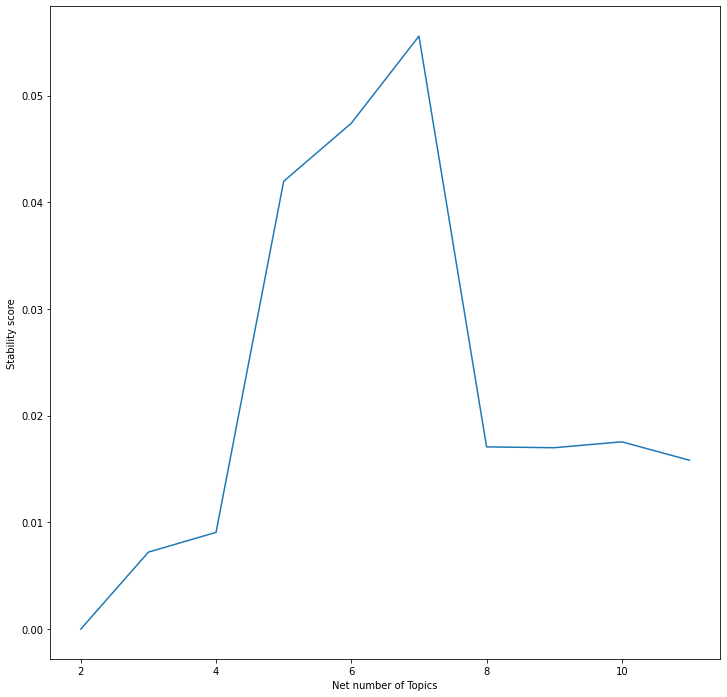

In [27]:
plt.figure(figsize=(12,12))
#for x,y in stability_scores.items():
x = list(stability_scores.keys())
y=list(stability_scores.values())
plt.plot(x,y)
plt.xlabel("Net number of Topics")
plt.ylabel("Stability score")
plt.show()